<a href="https://colab.research.google.com/github/Yadidya5/interannual-variability-IT-Andaman-Sea/blob/main/ORAS_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ORAS5 data analysis (BVF)**

Import libraries

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import xgcm as xg
#========================================================
import sys
sys.path.append('py_scripts')
import yadi
#========================================================

Read input data

In [2]:
f1 = xr.open_mfdataset("H:/ORAS_indianocean/*_oras_temp_indian_ocean.nc")
f2 = xr.open_mfdataset("H:/ORAS_indianocean/*_oras_salt_indian_ocean.nc")


In [6]:
s1 = f2.so[100,0:20,:,:].sel(longitude=slice(89,99),latitude=slice(4,17))
t1 = f1.thetao[100,0:20,:,:].sel(longitude=slice(89,99),latitude=slice(4,17))
p1 = f1.depth


#hans = dens(s,t,p).compute()

In [10]:
bvf(s1,t1,p1,"depth").compute()

<xarray.DataArray (depth: 20, latitude: 157, longitude: 121)>
array([[[ 3.952181 ,  3.952181 ,  3.952181 , ..., 10.878532 ,
         10.836221 , 10.639414 ],
        [ 4.2652545,  3.8818102,  3.952181 , ..., 10.716855 ,
         10.759638 , 10.699695 ],
        [ 4.286742 ,  4.308122 ,  3.952181 , ..., 10.768175 ,
         10.66529  , 10.482816 ],
        ...,
        [ 6.9254436,  6.8721704,  6.6823697, ...,        nan,
                nan,        nan],
        [ 6.991465 ,  6.9783106,  7.03078  , ...,        nan,
                nan,        nan],
        [ 7.08286  ,  6.898859 ,  7.095821 , ...,        nan,
                nan,        nan]],

       [[ 3.960519 ,  3.9967992,  3.9967992, ...,  9.526078 ,
          9.495724 ,  9.35277  ],
        [ 4.173473 ,  3.972649 ,  4.0088196, ...,  9.434723 ,
          9.444918 ,  9.388712 ],
        [ 4.1503506,  4.173473 ,  3.960519 , ...,  9.531127 ,
          9.347624 ,  9.223259 ],
...
        [12.83308  , 12.843854 , 12.849472 , ...,        nan,
                nan,        nan],
        [12.932985 , 12.941818 , 12.91763  , ...,        nan,
                nan,        nan],
        [13.0099535, 12.9970045, 12.943677 , ...,        nan,
                nan,        nan]],

       [[ 9.65867  ,  9.504665 ,  9.411461 , ...,        nan,
                nan,        nan],
        [ 9.93835  ,  9.786788 ,  9.697284 , ...,        nan,
                nan,        nan],
        [10.287037 , 10.151076 , 10.0428915, ...,        nan,
                nan,        nan],
        ...,
        [12.814662 , 12.8311   , 12.843043 , ...,        nan,
                nan,        nan],
        [12.898878 , 12.927076 , 12.902594 , ...,        nan,
                nan,        nan],
        [12.997302 , 12.978859 , 12.924853 , ...,        nan,
                nan,        nan]]], dtype=float32)
Coordinates:
    time       datetime64[ns] 2001-05-16T12:00:00
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 47.37 55.76 65.81
  * latitude   (latitude) float32 4.0 4.083 4.167 4.25 ... 16.83 16.92 17.0
  * longitude  (longitude) float32 89.0 89.08 89.17 89.25 ... 98.83 98.92 99.0

Functions to compute buoyancy frequency

In [8]:

def dens0(s,t):
    T68 = t * 1.0024
    # UNESCO 1983 Eqn.(13) p17.
    b = (8.24493e-1, -4.0899e-3, 7.6438e-5, -8.2467e-7, 5.3875e-9)
    c = (-5.72466e-3, 1.0227e-4, -1.6546e-6)
    d = 4.8314e-4
    return (smow(t) + (b[0] + (b[1] + (b[2] + (b[3] + b[4] * T68) * T68) *
            T68) * T68) * s + (c[0] + (c[1] + c[2] * T68) * T68) * s *
            s ** 0.5 + d * s ** 2)
def smow(t):
  """
    Density of Standard Mean Ocean Water (Pure Water) using EOS 1980.
  """
  a = (999.842594, 6.793952e-2, -9.095290e-3, 1.001685e-4, -1.120083e-6,
         6.536332e-9)

  T68 = t * 1.0024
  return (a[0] + (a[1] + (a[2] + (a[3] + (a[4] + a[5] * T68) * T68) * T68) *
            T68) * T68)

def seck(s,t,p):
  """
    Secant Bulk Modulus (K) of Sea Water using Equation of state 1980.
    UNESCO polynomial implementation.
  """
  # Compute compression terms.
  p = p / 10.0  # Convert from db to atmospheric pressure units.
  T68 = t * 1.0024

    # Pure water terms of the secant bulk modulus at atmos pressure.
    # UNESCO Eqn 19 p 18.
    # h0 = -0.1194975
  h = [3.239908, 1.43713e-3, 1.16092e-4, -5.77905e-7]
  AW = h[0] + (h[1] + (h[2] + h[3] * T68) * T68) * T68

    # k0 = 3.47718e-5
  k = [8.50935e-5, -6.12293e-6, 5.2787e-8]
  BW = k[0] + (k[1] + k[2] * T68) * T68

    # e0 = -1930.06
  e = [19652.21, 148.4206, -2.327105, 1.360477e-2, -5.155288e-5]
  KW = e[0] + (e[1] + (e[2] + (e[3] + e[4] * T68) * T68) * T68) * T68

    # Sea water terms of secant bulk modulus at atmos. pressure.
  j0 = 1.91075e-4
  i = [2.2838e-3, -1.0981e-5, -1.6078e-6]
  A = AW + (i[0] + (i[1] + i[2] * T68) * T68 + j0 * s ** 0.5) * s

  m = [-9.9348e-7, 2.0816e-8, 9.1697e-10]
  B = BW + (m[0] + (m[1] + m[2] * T68) * T68) * s  # Eqn 18.

  f = [54.6746, -0.603459, 1.09987e-2, -6.1670e-5]
  g = [7.944e-2, 1.6483e-2, -5.3009e-4]
  K0 = (KW + (f[0] + (f[1] + (f[2] + f[3] * T68) * T68) * T68 +
                (g[0] + (g[1] + g[2] * T68) * T68) * s ** 0.5) * s)  # Eqn 16.
  return K0 + (A + B * p) * p  # Eqn 15.

def dens(s,t,p):
  """
    Density of Sea Water using UNESCO 1983 (EOS 80) polynomial.
  """
  # UNESCO 1983. Eqn..7  p.15.
  densP0 = dens0(s, t)
  K = seck(s, t, p)
  p = p / 10.  # Convert from db to atm pressure units.
  return densP0 / (1 - p / K)

def bvf(s,t,p,zdim="depth"):
  den = dens(s,t,p)
  rhod = den.differentiate(zdim)
  g = 9.8
  rho0 = den.mean()
  bvfr2 = (g/rho0)*rhod
  n2 = (np.sqrt(np.abs(bvfr2))) * 60.0 * 60.0 / (2.0 * np.pi)
  return n2

In [ ]:
grid = xg.Grid(hans,periodic=['Z'])
grid

<xgcm.Grid>
Z Axis (periodic, boundary=None):
  * center   depth
T Axis (not periodic, boundary=None):
  * center   time

In [ ]:
print(hans[0,:].differentiate("depth"))
print(hans[0,:])


<xarray.DataArray (depth: 30)>
array([0.02424273, 0.02328491, 0.01895142, 0.01422119, 0.01223755,
       0.01138306, 0.01074219, 0.01055908, 0.01156616, 0.01316833,
       0.01654053, 0.02160645, 0.026474  , 0.03112793, 0.03424835,
       0.03549957, 0.03604126, 0.03384399, 0.02842712, 0.02228546,
       0.01747131, 0.01472664, 0.01387978, 0.0144043 , 0.01488781,
       0.01375484, 0.01187229, 0.00971317, 0.0074029 , 0.00638019],
      dtype=float32)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 3.819 ... 266.0 318.1 380.2
    latitude   float32 -24.17
    time       datetime64[ns] 1993-01-16T12:00:00
    longitude  float32 53.33
<xarray.DataArray (depth: 30)>
array([1022.9436 , 1022.969  , 1022.9935 , 1023.01166, 1023.02783,
       1023.0436 , 1023.06036, 1023.0771 , 1023.09717, 1023.1224 ,
       1023.1557 , 1023.2072 , 1023.2828 , 1023.3874 , 1023.52997,
       1023.7043 , 1023.918  , 1024.1704 , 1024.4337 , 1024.6836 ,
       1024.9147 , 1025.1378 , 1025.3798 , 1025

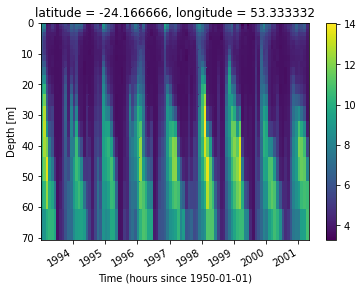

In [ ]:
rho1 = hans.differentiate("depth")
g = -9.8
rho0 = hans.mean()
bvfr2 = (g/rho0)*rho1

n2 = (np.sqrt(np.abs(bvfr2))) * 60.0 * 60.0 / (2.0 * np.pi)
n2[:,0:20].plot(yincrease=False,y='depth')